# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


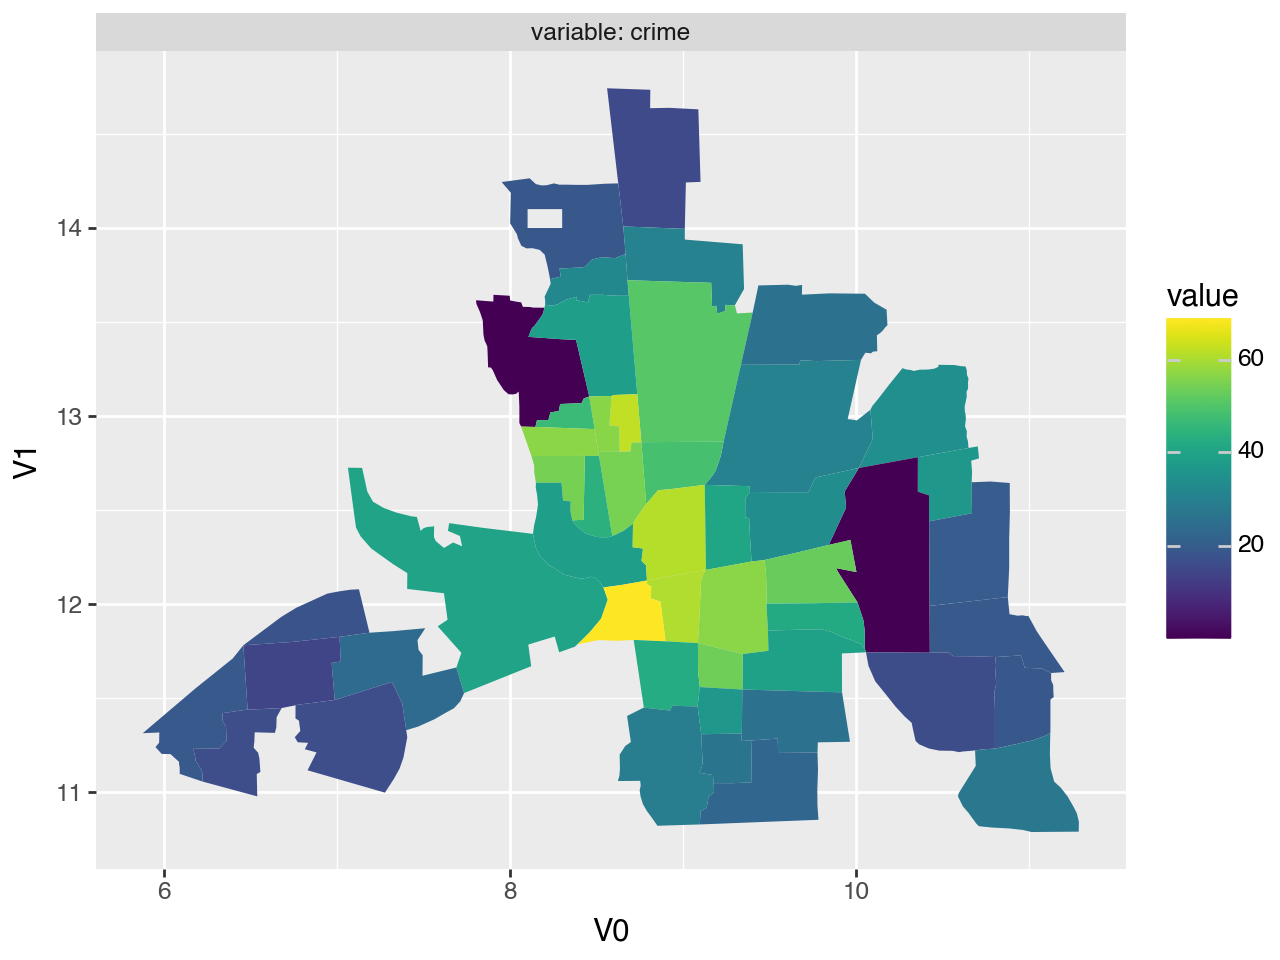

In [3]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [4]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf(
    "district",
    polys=polys,
    absorb_cons=True,
    diagonal_penalty=True,
    scale_penalty=True,
    noncentered=True,
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


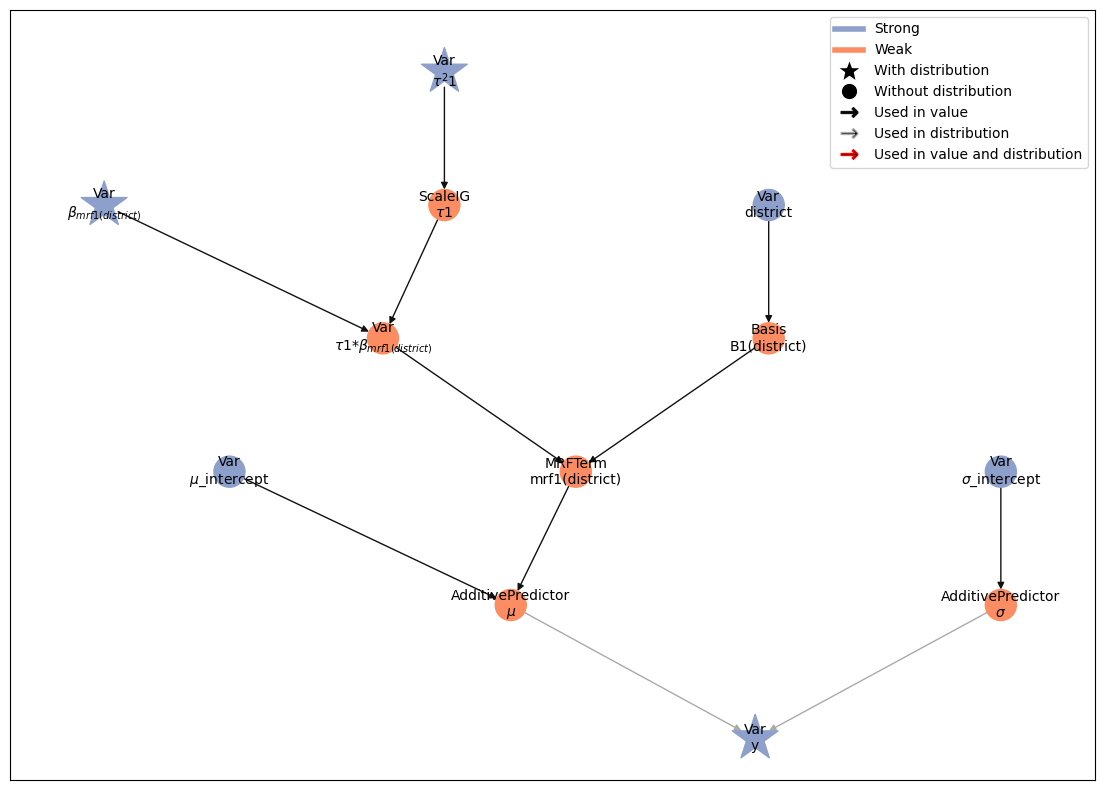

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{mrf1(district)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.32chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1329.41chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1592.37chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO -

### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean        sd     q_0.05  \
parameter                index                                              
$\beta_{mrf1(district)}$ (0,)   kernel_02   0.157642  1.030108  -1.575486   
                         (1,)   kernel_02   0.005542  0.991507  -1.619361   
                         (2,)   kernel_02   0.133636  0.997394  -1.542077   
                         (3,)   kernel_02   0.184532  1.002545  -1.486846   
                         (4,)   kernel_02   0.062198  0.963802  -1.535161   
                         (5,)   kernel_02  -0.014540  0.965342  -1.596744   
                         (6,)   kernel_02  -0.074111  0.998800  -1.730475   
                         (7,)   kernel_02   0.024903  0.942495  -1.514259   
                         (8,)   kernel_02  -0.027592  0.970942  -1.615655   
                         (9,)   kernel_02   0.199067  1.034197  -1.513588   
                         (10,)  kernel_02   0.050188  0.979566  -1.553439   
                         (11,)  kernel_02  -0.047655  0.973283  -1.656222   
                         (12,)  kernel_02   0.015032  0.954368  -1.555885   
                         (13,)  kernel_02  -0.001290  0.946879  -1.537450   
                         (14,)  kernel_02  -0.002813  0.966069  -1.579662   
                         (15,)  kernel_02  -0.196567  1.041546  -1.920827   
                         (16,)  kernel_02   0.053727  0.978764  -1.572957   
                         (17,)  kernel_02   0.031123  0.969886  -1.573668   
                         (18,)  kernel_02   0.069376  0.985759  -1.535656   
                         (19,)  kernel_02  -0.142256  0.989318  -1.762671   
                         (20,)  kernel_02   0.129657  0.965075  -1.483115   
                         (21,)  kernel_02   0.357788  1.072156  -1.391291   
                         (22,)  kernel_02   0.029110  0.958757  -1.576274   
                         (23,)  kernel_02  -0.079066  0.971468  -1.635599   
                         (24,)  kernel_02  -0.132466  1.007558  -1.754056   
                         (25,)  kernel_02   0.051742  0.959734  -1.504416   
                         (26,)  kernel_02  -0.089880  0.993096  -1.673644   
                         (27,)  kernel_02  -0.060977  0.965330  -1.632988   
                         (28,)  kernel_02  -0.139271  0.975678  -1.702234   
                         (29,)  kernel_02  -0.115409  0.979578  -1.696947   
                         (30,)  kernel_02   0.109039  0.971202  -1.528351   
                         (31,)  kernel_02  -0.089219  0.969858  -1.677064   
                         (32,)  kernel_02  -0.204519  1.001820  -1.802176   
                         (33,)  kernel_02   0.096064  0.977930  -1.536394   
                         (34,)  kernel_02  -0.125031  0.959146  -1.670668   
                         (35,)  kernel_02   0.164337  0.948244  -1.420122   
                         (36,)  kernel_02   0.182679  0.967074  -1.461225   
                         (37,)  kernel_02  -0.100038  0.964023  -1.664411   
                         (38,)  kernel_02  -0.063165  0.943451  -1.619587   
                         (39,)  kernel_02   0.215618  0.985973  -1.440748   
                         (40,)  kernel_02  -0.332728  1.006416  -1.914114   
                         (41,)  kernel_02   0.277272  0.982897  -1.408931   
                         (42,)  kernel_02  -0.401689  1.031796  -2.003218   
                         (43,)  kernel_02   0.248050  0.934168  -1.347745   
                         (44,)  kernel_02  -0.585007  1.068060  -2.175721   
                         (45,)  kernel_02  -0.646155  1.080088  -2.229728   
                         (46,)  kernel_02  -0.237466  0.895542  -1.639505   
                         (47,)  kernel_02   0.571311  0.913021  -1.098540   
$\mu$_intercept          ()     kernel_01  35.099476  2.282254  31.325129   
$\sigma$_intercept       ()     kernel_00   2.728227 

## Plots

In [8]:
samples = results.get_posterior_samples()

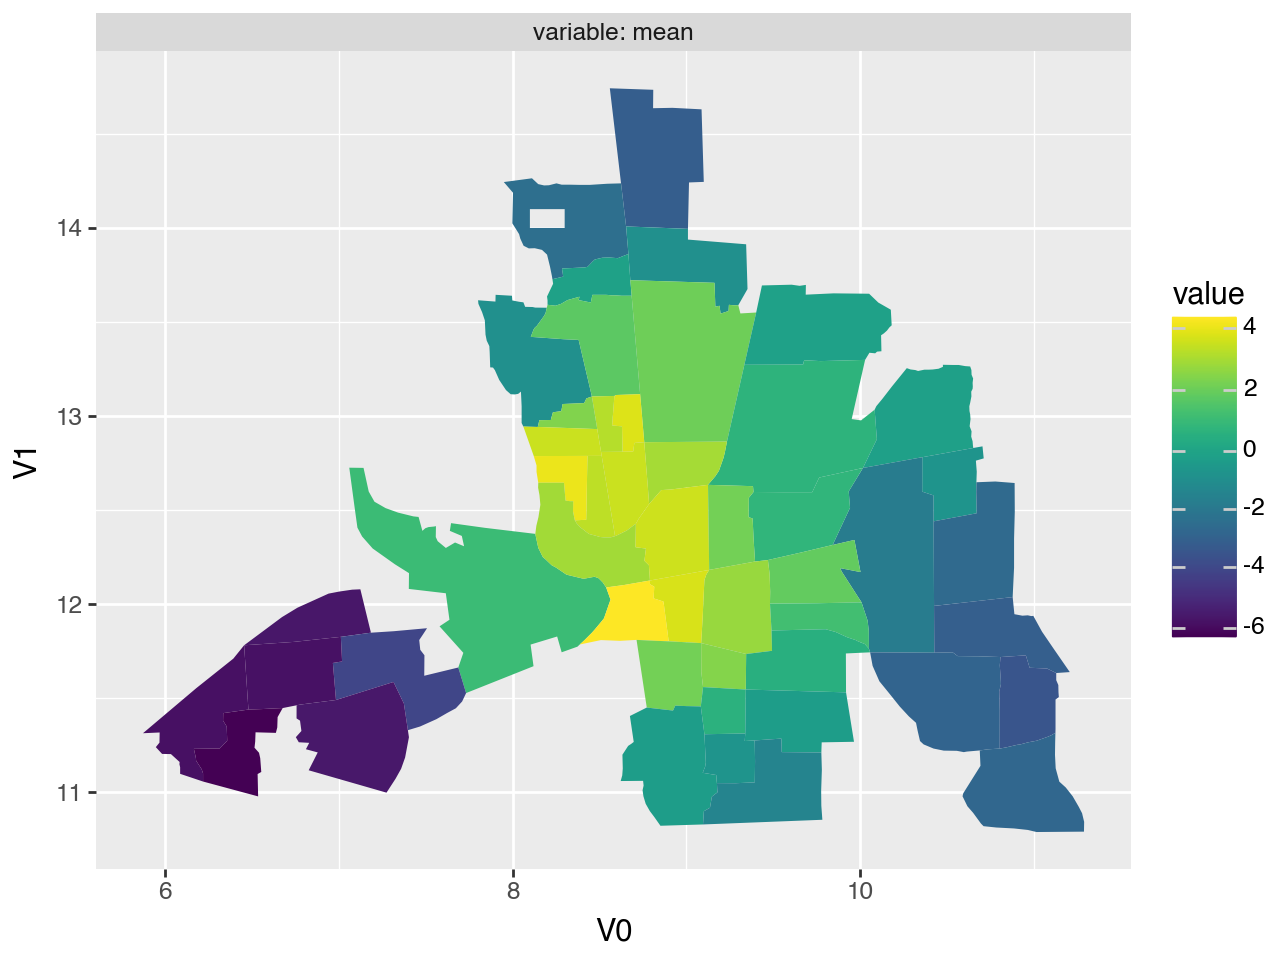

In [9]:
gam.plot_regions(term=loc.terms["mrf1(district)"], samples=samples, polys=polys)

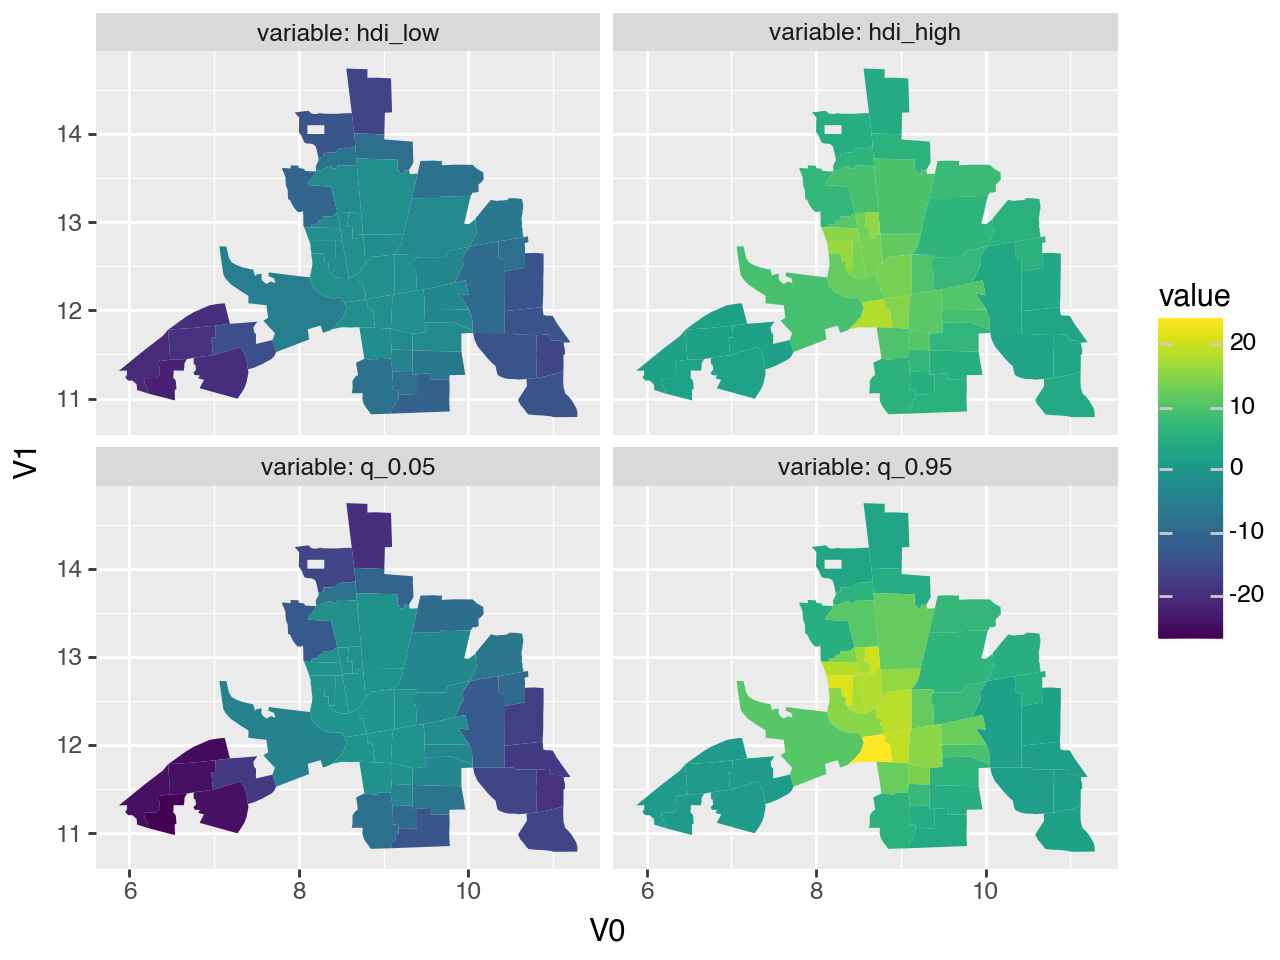

In [10]:
gam.plot_regions(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    polys=polys,
    which=["hdi_low", "hdi_high", "q_0.05", "q_0.95"],
)

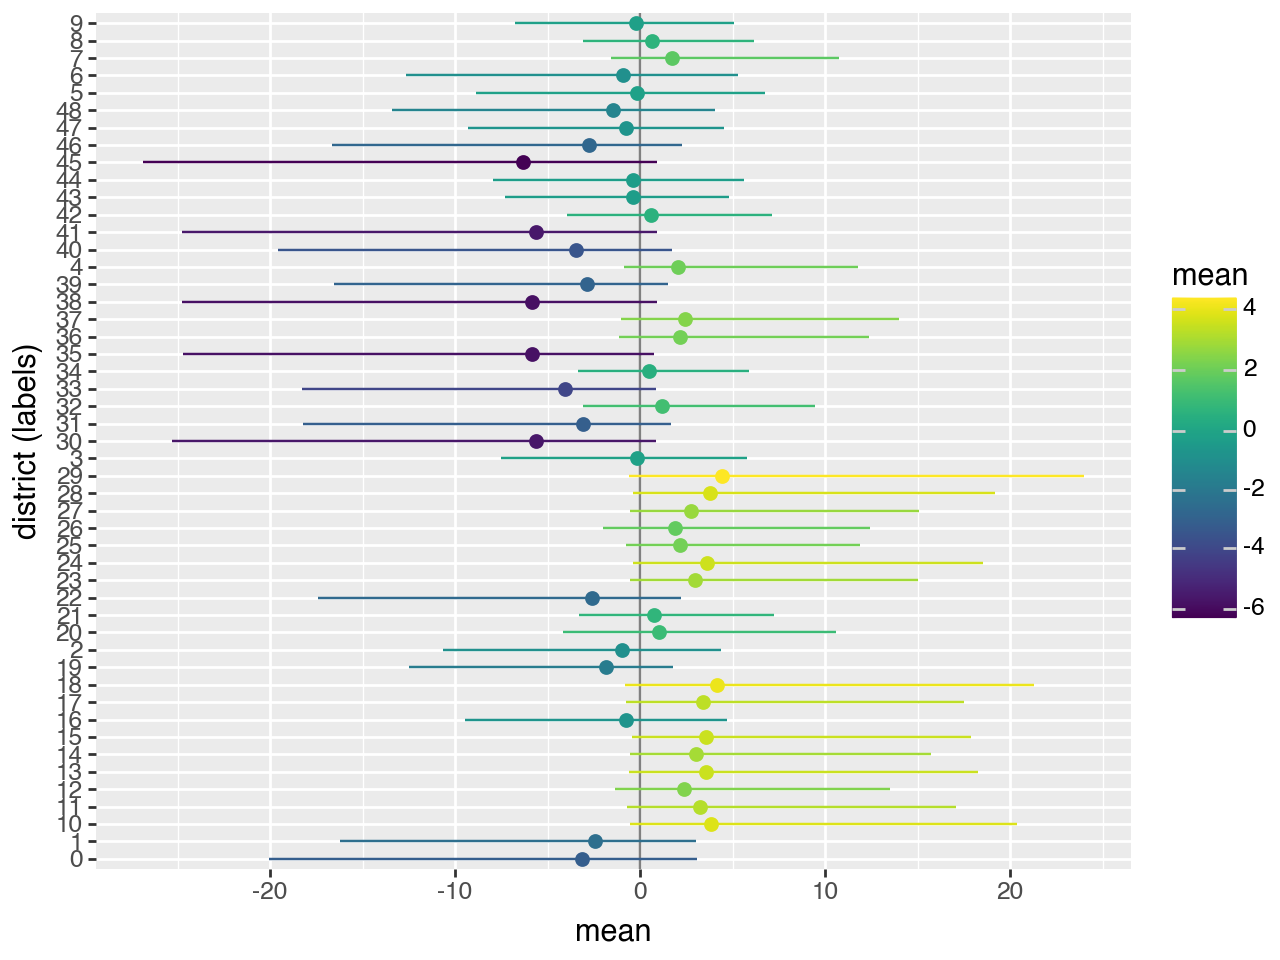

In [11]:
gam.plot_forest(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    # labels=tb.bases.mappings["district"],
    ymin="q_0.05",
    ymax="q_0.95",
)